In [1]:
import os

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
from torchvision.utils import make_grid
import torchvision.transforms as tt
import torch
import torch.nn as nn

import cv2
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


#### 1) Fetching data

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/AI_Notebooks/Kaggle"

In [ ]:
%cd /content/drive/MyDrive/AI_Notebooks/Kaggle/

/content/drive/MyDrive/AI_Notebooks/Kaggle


In [ ]:
!kaggle datasets download -d arnaud58/flickrfaceshq-dataset-ffhq

100% 19.4G/19.5G [02:05<00:00, 164MB/s]
100% 19.5G/19.5G [02:05<00:00, 167MB/s]


In [ ]:
%cd ~/../content

/content


In [ ]:
!unzip -q /content/drive/MyDrive/AI_Notebooks/Kaggle/flickrfaceshq-dataset-ffhq.zip -d flickr_faces

In [ ]:
%cd flickr_faces
!ls | wc -l
%cd ..

/content/flickr_faces
52001
/content


In [ ]:
DATA_PATH = "./flickr_faces/"

#### 2) Preprocessing data

In [ ]:
image_size = 512
batch_size = 64      
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)       # means and std's for normalization

# ImageFolder нуждается в том, чтобы все изображения в директории
# были разложены по "классовым" папкам. Удовлетворим его прихоть:

In [ ]:
%cd flickr_faces         
!mkdir faces             
!mv *.png faces
%cd ..

/content/flickr_faces
/content


In [ ]:
# Create dataset as torch ImageFolder supplied with transformations

train_ds = ImageFolder(DATA_PATH, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))

In [ ]:
# Create dataloader

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

In [ ]:
# "Снимаем" нормализацию с картинок
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]


def show_images(images, nmax=16):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=4).permute(1, 2, 0))


def show_batch(dl, nmax=16):
    for images, _ in dl:
        show_images(images, nmax)
        break

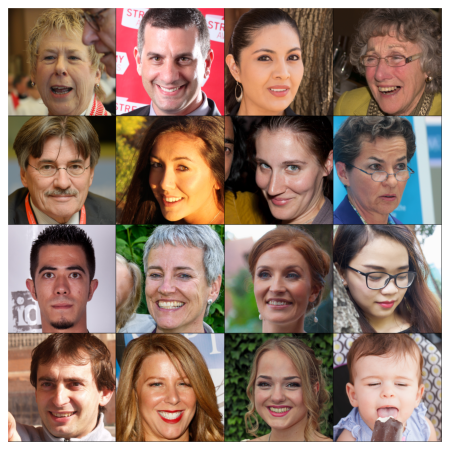

In [ ]:
show_batch(train_dl)

In [ ]:
# Посмотрим, что представляет из себя батч в плане данных и размерности

for im_batch, cls_batch in train_dl:
    print(f"im_batch: {type(im_batch)}, {im_batch.shape}")
    print(f"cls_batch: {type(cls_batch)}, {cls_batch.shape}")

    break

im_batch: <class 'torch.Tensor'>, torch.Size([64, 3, 512, 512])
cls_batch: <class 'torch.Tensor'>, torch.Size([64])


In [ ]:
def to_device(data: torch.Tensor, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    
    return data.to(device, non_blocking=True)


# Декоратор для DataLoader, который будет переносить батчи на GPU
class DeviceDataLoader():

    def __init__(self, dl: DataLoader, device):
        self.dl = dl
        self.device = device
    
    def __len__(self):
        return len(self.dl)
    
    def __iter__(self):
        for batch in self.dl: 
            yield to_device(batch, self.device)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

#### 3) Построение архитектуры сети

In [ ]:
discriminator = nn.Sequential(
    # input: 3 x 512 x 512
    nn.Conv2d(3, 32, kernel_size=4, padding=1, stride=2, bias=False),
    nn.LeakyReLU(negative_slope=0.2, inplace=True),
    # -> 32 x 256 x 256

    nn.Conv2d(32, 64, kernel_size=4, padding=1, stride=2, bias=False), 
    nn.BatchNorm2d(num_features=64),                                            
    nn.LeakyReLU(negative_slope=0.2, inplace=True),
    # -> 64 x 128 x 128

    nn.Conv2d(64, 128, kernel_size=4, padding=1, stride=2, bias=False),
    nn.MaxPool2d(kernel_size=2),
    nn.BatchNorm2d(num_features=128),
    nn.LeakyReLU(negative_slope=0.2, inplace=True), 
    # -> 128 x 32 x 32                        

    nn.Conv2d(128, 256, kernel_size=4, padding=1, stride=2, bias=False),
    nn.MaxPool2d(kernel_size=2),
    nn.BatchNorm2d(num_features=256),
    nn.LeakyReLU(negative_slope=0.2, inplace=True),   
    # -> 256 x 8 x 8                       

    nn.Conv2d(256, 512, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(num_features=512),
    nn.LeakyReLU(negative_slope=0.2, inplace=True),
    # -> 512 x 4 x 4                            

    nn.Conv2d(in_channels=512, out_channels=1, kernel_size=4, padding=0, bias=False),
    # -> 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
)

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_dim = 128

In [ ]:
generator = nn.Sequential(
    # input: latent_dim x 1 x 1
    nn.ConvTranspose2d(latent_dim, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    # -> 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(num_features=256),
    nn.ReLU(inplace=True),
    # -> 256 x 8 x 8 

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(num_features=128),
    nn.ReLU(inplace=True),
    # -> 128 x 16 x 16   

    nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(num_features=128),
    nn.ReLU(inplace=True),
    # -> 128 x 32 x 32

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(num_features=64),
    nn.ReLU(inplace=True),
    # -> 64 x 64 x 64

    nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(num_features=64),
    nn.ReLU(inplace=True),
    # -> 64 x 128 x 128

    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(num_features=32),
    nn.ReLU(inplace=True),
    # -> 32 x 256 x 256

    nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1, bias=False),      # there was additional ReLU after Conv
    # -> 3 x 512 x 512   

    nn.Tanh()                                     
)

torch.Size([64, 3, 512, 512])


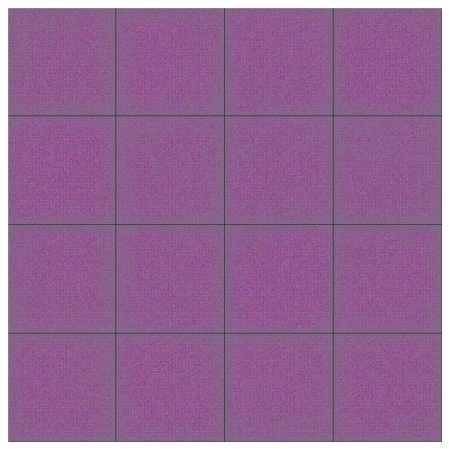

In [ ]:
trial_noize = torch.randn(batch_size, latent_dim, 1, 1) 
fake_images = generator(trial_noize)

print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
fixed_latent = torch.randn(16, latent_dim, 1, 1, device=device)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=4)
    print('Saving', fake_fname)

    if show:
        # fig, ax = plt.subplots(figsize=(8, 8))
        # ax.set_xticks([]); ax.set_yticks([])
        # ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))
        show_images(fake_images)

#### 4) Обучение

In [ ]:
def fit(model, criterion, lr, num_epochs, start_idx=1):

    # Gen and Des to the train mode
    model["discriminator"].train()
    model["generator"].train()

    # Losses & scores lists
    losses_g = list()
    losses_d = list()
    real_scores = list()
    fake_scores = list()

    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }

    for epoch in range(num_epochs):

        loss_d_per_epoch = list()
        loss_g_per_epoch = list()
        fake_score_per_epoch = list()
        real_score_per_epoch = list()

        for real_images, _ in tqdm(train_dl):

            # Discriminator block
            optimizer["discriminator"].zero_grad()

            latent_samples = torch.randn(real_images.size(0), latent_dim, 1, 1, device=device)
            generated = model["generator"](latent_samples)
            fake_labels = torch.zeros(real_images.size(0), 1, device=device)
            real_labels = torch.ones(real_images.size(0), 1, device=device)

            real_preds = model["discriminator"](real_images)
            fake_preds = model["discriminator"](generated)
            fake_loss = criterion["discriminator"](fake_preds, fake_labels)
            real_loss = criterion["discriminator"](real_preds, real_labels)
            
            total_discriminator_loss = fake_loss + real_loss
            total_discriminator_loss.backward()
            optimizer["discriminator"].step()


            # Generator block
            optimizer["generator"].zero_grad()

            latent_samples_new = torch.randn(real_images.size(0), latent_dim, 1, 1, device=device)
            real_labels_new = torch.ones(real_images.size(0), 1, device=device)
            generated = model["generator"](latent_samples_new)

            gen_loss = criterion["generator"](model["discriminator"](generated), real_labels_new)
            gen_loss.backward()
            optimizer["generator"].step()


            # Record losses & scores per batch
            loss_d_per_epoch.append(total_discriminator_loss.item())
            loss_g_per_epoch.append(gen_loss.item())
            fake_score_per_epoch.append(torch.mean(fake_preds).item())
            real_score_per_epoch.append(torch.mean(real_preds).item())
        
        # Record losses & scores per epoch
        losses_d.append(np.mean(loss_d_per_epoch))
        losses_g.append(np.mean(loss_g_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))

        print(f"Epoch [{epoch+1}/{num_epochs}]: loss_d: {losses_d[-1]:.4f}, loss_g: {losses_g[-1]:.4f},\
        real_score: {real_scores[-1]:.4f}, fake_score:{fake_scores[-1]:.4f}")

        # Save generated images
        if epoch == num_epochs - 1:
          save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_d, losses_g, real_scores, fake_scores
    

In [ ]:
model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

lr = 0.0002
epochs = 20

In [ ]:
history = fit(model, criterion, lr, epochs)

  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [1/20]: loss_d: 0.1195, loss_g: 7.4053,        real_score: 0.9698, fake_score:0.0389


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [2/20]: loss_d: 0.0005, loss_g: 8.5835,        real_score: 0.9997, fake_score:0.0003


  0%|          | 0/813 [00:00<?, ?it/s]

Epoch [3/20]: loss_d: 0.0002, loss_g: 9.5644,        real_score: 0.9999, fake_score:0.0001


  0%|          | 0/813 [00:00<?, ?it/s]